In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-model/best_model.hdf5
/kaggle/input/bestmodel/best_model1.hdf5
/kaggle/input/bestmodel/bm12.JPG
/kaggle/input/bestmodel/bm11.JPG
/kaggle/input/basemodel5/bm51.JPG
/kaggle/input/basemodel5/best_model4(1).hdf5
/kaggle/input/basemodel5/bm52.JPG
/kaggle/input/bestmodel6/bm61.JPG
/kaggle/input/bestmodel6/best_model4(3).hdf5
/kaggle/input/bestmodel6/bm62.JPG
/kaggle/input/bestmodel3/bm42.JPG
/kaggle/input/bestmodel3/bm41.JPG
/kaggle/input/bestmodel3/best_model3.hdf5
/kaggle/input/bestmodel2/bm22.JPG
/kaggle/input/bestmodel2/bm21.JPG
/kaggle/input/bestmodel2/best_model2.hdf5
/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv


In [2]:
!nvidia-smi

Wed May 19 02:25:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import math


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB6

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


# Большая част кода ноутбука закоментирована, чтобы пройденные этапы обучения не перезапускалиь при перезапусках. Результаты выполнения закоментированного кода приведены в следующих ячейках.

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
RANDOM_SEED          = 100

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория



In [5]:
 #EDA (Разведывательный анализ данных)
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [7]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [8]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


In [9]:
#посмотрим на данные
train_df.head(3)

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0


In [10]:
train_df.Category.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<AxesSubplot:>

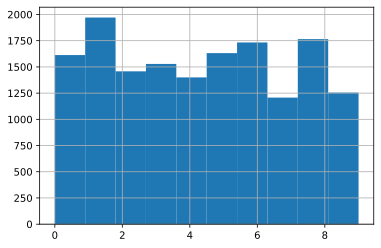

In [11]:
train_df.Category.hist(bins = 10)
#категории представленны относительно равномерно.
#меньше всего примеров 7 и 9 категории, возможно в будующем это нужно будет учесть

In [12]:
train_df.info()
#пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


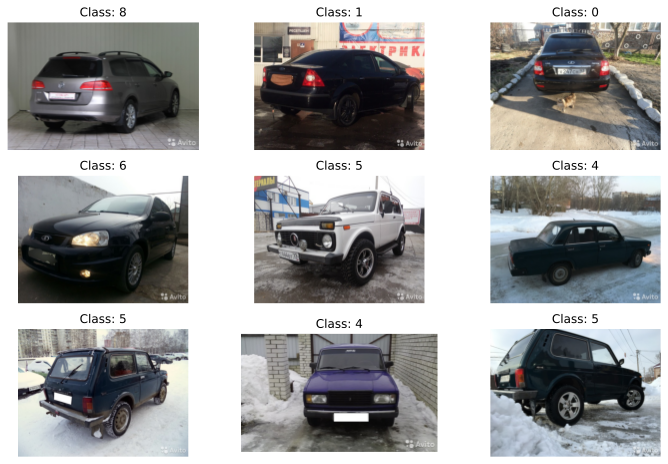

In [13]:
#Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

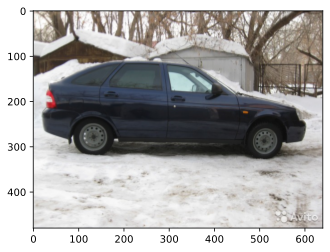

(640, 480)

In [14]:
#0 категория - Priora
#1 категория - Ford Focus
#2 категория - Samara 2114
#3 категория - 110
#4 категория - 2107
#5 категория - Niva
#6 категория - Kalina
#7 категория - Samara 2109
#8 категория - Volkswagen Passat
#9 категория - Samara 21099

image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [15]:
#Аугментация данных
train_datagen = ImageDataGenerator(
    rescale=1. / 255, #коэффициент масштабирования. По умолчанию - Нет. Если Нет или 0, 
    #масштабирование не применяется, в противном случае мы умножаем данные на предоставленное значение 
    #(после применения всех остальных преобразований).
    
    rotation_range = 5, #угол случайных поворотов
    width_shift_range = 0.1, #диапазон сдвига ширины
    height_shift_range = 0.1, #диапазон сдвига высоты
    brightness_range =  [0.5, 1.5], # сдвиг яркости
    validation_split = VAL_SPLIT, # Доля выборки для валидации 
    horizontal_flip = True  # отражение по горизонтали
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [16]:
#Генерация данных
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [17]:
!pip install -q efficientnet

In [18]:
#Строим модель
import efficientnet.tfkeras as efn
#Загружаем предобученную сеть Xception:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

# загружаем базовую модель
#base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)
# отключаем обучаемость базовой модели
#base_model.trainable = False

In [19]:
#base_model.summary()
#Устанавливаем новую «голову» (head):
#x = base_model.output
#x = GlobalAveragePooling2D()(x)  #Pooling слой
#x = Dense(256, activation='elu')(x) # полносвязный слой с активацией elu
#x = BatchNormalization()(x) #добавим Batch нормализацию
#x = Dropout(0.25)(x) # полносвязный слой с вероятность отключения нейронов в слое
   #x = BatchNormalization(axis = 1)(x) #добавим Batch нормализацию
#predictions = Dense(CLASS_NUM, activation='softmax')(x) #логистический слой c нас 10 классами

# первая векрсия модели
#model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [20]:
#model.summary()

In [21]:
#Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели,
#чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model1.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

#останоить обучение, когда метрика перестает улучшаться.
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True)

#Снижайть скорость обучения, когда метрика перестает улучшаться.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=0.0000001, verbose=1, mode='auto')
    
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [22]:
#Обучаем модель
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = len(train_generator),
#        validation_data = test_generator, 
#        validation_steps = len(test_generator),
#        epochs = 20, #EPOCHS,
#        callbacks = callbacks_list
#)

Epoch 1/20
207/207 [==============================] - 253s 1s/step - loss: 1.2439 - accuracy: 0.5732 - val_loss: 0.9490 - val_accuracy: 0.6617

Epoch 00001: saving model to best_model1.hdf5
Epoch 2/20
207/207 [==============================] - 253s 1s/step - loss: 1.1935 - accuracy: 0.5880 - val_loss: 0.8739 - val_accuracy: 0.6964

Epoch 00002: saving model to best_model1.hdf5
Epoch 3/20
207/207 [==============================] - 253s 1s/step - loss: 1.1534 - accuracy: 0.6034 - val_loss: 0.8842 - val_accuracy: 0.6934

Epoch 00003: saving model to best_model1.hdf5
Epoch 4/20
207/207 [==============================] - 256s 1s/step - loss: 1.1383 - accuracy: 0.6054 - val_loss: 0.8413 - val_accuracy: 0.7110

Epoch 00004: saving model to best_model1.hdf5
Epoch 5/20
207/207 [==============================] - 253s 1s/step - loss: 1.1136 - accuracy: 0.6142 - val_loss: 0.8358 - val_accuracy: 0.7080

Epoch 00005: saving model to best_model1.hdf5
Epoch 6/20
207/207 [==============================] - 254s 1s/step - loss: 1.0963 - accuracy: 0.6184 - val_loss: 0.8060 - val_accuracy: 0.7205

Epoch 00006: saving model to best_model1.hdf5
Epoch 7/20
207/207 [==============================] - 255s 1s/step - loss: 1.0752 - accuracy: 0.6288 - val_loss: 0.7854 - val_accuracy: 0.7235

Epoch 00007: saving model to best_model1.hdf5
Epoch 8/20
207/207 [==============================] - 257s 1s/step - loss: 1.0528 - accuracy: 0.6369 - val_loss: 0.7860 - val_accuracy: 0.7295

Epoch 00008: saving model to best_model1.hdf5
Epoch 9/20
207/207 [==============================] - 259s 1s/step - loss: 1.0382 - accuracy: 0.6360 - val_loss: 0.7695 - val_accuracy: 0.7295

Epoch 00009: saving model to best_model1.hdf5
Epoch 10/20
207/207 [==============================] - 260s 1s/step - loss: 1.0298 - accuracy: 0.6375 - val_loss: 0.7618 - val_accuracy: 0.7304

Epoch 00010: saving model to best_model1.hdf5
Epoch 11/20
207/207 [==============================] - 261s 1s/step - loss: 1.0239 - accuracy: 0.6479 - val_loss: 0.7885 - val_accuracy: 0.7201

Epoch 00011: saving model to best_model1.hdf5
Epoch 12/20
207/207 [==============================] - 261s 1s/step - loss: 0.9975 - accuracy: 0.6512 - val_loss: 0.7763 - val_accuracy: 0.7316

Epoch 00012: saving model to best_model1.hdf5

Epoch 00012: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 13/20
207/207 [==============================] - 261s 1s/step - loss: 0.9692 - accuracy: 0.6600 - val_loss: 0.7364 - val_accuracy: 0.7411

Epoch 00013: saving model to best_model1.hdf5
Epoch 14/20
207/207 [==============================] - 261s 1s/step - loss: 0.9711 - accuracy: 0.6556 - val_loss: 0.7146 - val_accuracy: 0.7505

Epoch 00014: saving model to best_model1.hdf5
Epoch 15/20
207/207 [==============================] - 261s 1s/step - loss: 0.9650 - accuracy: 0.6629 - val_loss: 0.7237 - val_accuracy: 0.7505

Epoch 00015: saving model to best_model1.hdf5
Epoch 16/20
207/207 [==============================] - 261s 1s/step - loss: 0.9449 - accuracy: 0.6641 - val_loss: 0.7278 - val_accuracy: 0.7501

Epoch 00016: saving model to best_model1.hdf5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 17/20
207/207 [==============================] - 263s 1s/step - loss: 0.9569 - accuracy: 0.6641 - val_loss: 0.7056 - val_accuracy: 0.7553

Epoch 00017: saving model to best_model1.hdf5
Epoch 18/20
207/207 [==============================] - 263s 1s/step - loss: 0.9433 - accuracy: 0.6706 - val_loss: 0.7175 - val_accuracy: 0.7527

Epoch 00018: saving model to best_model1.hdf5
Epoch 19/20
207/207 [==============================] - 263s 1s/step - loss: 0.9597 - accuracy: 0.6662 - val_loss: 0.7171 - val_accuracy: 0.7578

Epoch 00019: saving model to best_model1.hdf5

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 20/20
207/207 [==============================] - 263s 1s/step - loss: 0.9332 - accuracy: 0.6702 - val_loss: 0.7031 - val_accuracy: 0.7583

Epoch 00020: saving model to best_model1.hdf5

In [23]:
#Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model):
#model.save('../working/model_last1.hdf5')
#model.load_weights('../input/bestmodel/best_model1.hdf5')
#model.load_weights('best_model1.hdf5')

In [24]:
#scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 39s 1s/step - loss: 0.7108 - accuracy: 0.7488
Accuracy: 74.88%

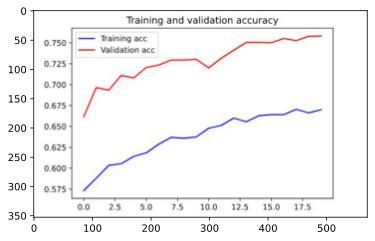

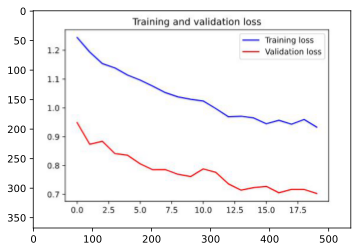

(538, 368)

In [25]:
#Посмотрим на графики обучения:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

#plot_history(history)

image = PIL.Image.open('../input/bestmodel/bm11.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size
image = PIL.Image.open('../input/bestmodel/bm12.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size

Из рассмотренных моделей EfficientNetB6 оказалась наиболее выгодной по параметрам скорость обучения-точность.
По графикам видно что модель не доучилась, но скорость обучения сильно упала, по этому имеет смысл переходить к следующему этапу.

In [26]:
#print("Number of layers in the base model: ", len(model.layers))
#len(model.trainable_variables)

In [27]:
#разморозим треть слоев
#model.trainable = True
#fine_tune_at = len(model.layers)-len(model.layers)//3

#for layer in model.layers[:fine_tune_at]:
#  layer.trainable =  False

#len(model.trainable_variables)

In [28]:
#Проверка состояния обучения отдельных слоев
#for layer in model.layers:
#    print(layer, layer.trainable)

In [29]:
LR=0.0001

#Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели,
#чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model2.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

#останоить обучение, когда метрика перестает улучшаться.
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True)

#Снижайть скорость обучения, когда метрика перестает улучшаться.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=0.0000001, verbose=1, mode='auto')
    
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [30]:
#model.summary()

           
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           batch_normalization[0][0]        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           2570        dropout[0][0]                    
==================================================================================================
Total params: 41,553,810

Trainable params: 40,632,062

Non-trainable params: 921,748

In [31]:
#обучаем
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = train_generator.samples//train_generator.batch_size,
#        validation_data = test_generator, 
#        validation_steps = test_generator.samples//test_generator.batch_size,
#        epochs = 10,
#        callbacks = callbacks_list
#)

Epoch 1/10
206/206 [==============================] - 293s 1s/step - loss: 1.4957 - accuracy: 0.5062 - val_loss: 0.5622 - val_accuracy: 0.7986

Epoch 00001: saving model to best_model2.hdf5
Epoch 2/10
206/206 [==============================] - 274s 1s/step - loss: 0.6690 - accuracy: 0.7625 - val_loss: 0.4097 - val_accuracy: 0.8594

Epoch 00002: saving model to best_model2.hdf5
Epoch 3/10
206/206 [==============================] - 272s 1s/step - loss: 0.4368 - accuracy: 0.8444 - val_loss: 0.3197 - val_accuracy: 0.8854

Epoch 00003: saving model to best_model2.hdf5
Epoch 4/10
206/206 [==============================] - 270s 1s/step - loss: 0.3532 - accuracy: 0.8775 - val_loss: 0.2798 - val_accuracy: 0.8941

Epoch 00004: saving model to best_model2.hdf5
Epoch 5/10
206/206 [==============================] - 269s 1s/step - loss: 0.2631 - accuracy: 0.9061 - val_loss: 0.2689 - val_accuracy: 0.9032

Epoch 00005: saving model to best_model2.hdf5
Epoch 6/10
206/206 [==============================] - 268s 1s/step - loss: 0.2435 - accuracy: 0.9122 - val_loss: 0.2655 - val_accuracy: 0.9119

Epoch 00006: saving model to best_model2.hdf5
Epoch 7/10
206/206 [==============================] - 270s 1s/step - loss: 0.1975 - accuracy: 0.9272 - val_loss: 0.2691 - val_accuracy: 0.9089

Epoch 00007: saving model to best_model2.hdf5
Epoch 8/10
206/206 [==============================] - 272s 1s/step - loss: 0.1603 - accuracy: 0.9426 - val_loss: 0.2612 - val_accuracy: 0.9158

Epoch 00008: saving model to best_model2.hdf5
Epoch 9/10
206/206 [==============================] - 273s 1s/step - loss: 0.1432 - accuracy: 0.9452 - val_loss: 0.2539 - val_accuracy: 0.9184

Epoch 00009: saving model to best_model2.hdf5
Epoch 10/10
206/206 [==============================] - 269s 1s/step - loss: 0.1407 - accuracy: 0.9483 - val_loss: 0.2666 - val_accuracy: 0.9214

Epoch 00010: saving model to best_model2.hdf5

In [32]:
#model.save('../working/model_step2.hdf5')
#model.load_weights('best_model2.hdf5')

In [33]:
#scores = model.evaluate_generator(test_generator, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 38s 1s/step - loss: 0.1911 - accuracy: 0.9407
Accuracy: 94.07%

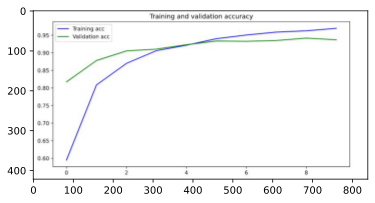

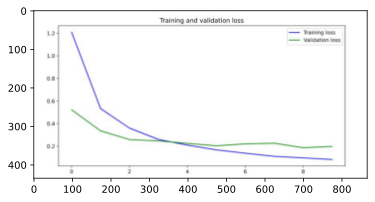

(866, 435)

In [34]:
#plot_history(history)

image = PIL.Image.open('../input/bestmodel2/bm21.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size
image = PIL.Image.open('../input/bestmodel2/bm22.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size

In [35]:
#разморозим еще часть слоев
#model.trainable = True
#fine_tune_at = len(model.layers)//3

#for layer in model.layers[:fine_tune_at]:
#  layer.trainable =  False

#len(model.trainable_variables)

In [36]:
LR=0.0001

#Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели,
#чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model3.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

#останоить обучение, когда метрика перестает улучшаться.
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True)

#Снижайть скорость обучения, когда метрика перестает улучшаться.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=0.0000001, verbose=1, mode='auto')
    
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [37]:
#Обучаем модель
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = len(train_generator),
#        validation_data = test_generator, 
#        validation_steps = len(test_generator),
#        epochs = 10, #EPOCHS,
#        callbacks = callbacks_list
#)

Epoch 1/10
207/207 [==============================] - 315s 1s/step - loss: 0.1873 - accuracy: 0.9301 - val_loss: 0.2361 - val_accuracy: 0.9266

Epoch 00001: saving model to best_model3.hdf5
Epoch 2/10
207/207 [==============================] - 292s 1s/step - loss: 0.1122 - accuracy: 0.9573 - val_loss: 0.2464 - val_accuracy: 0.9257

Epoch 00002: saving model to best_model3.hdf5
Epoch 3/10
207/207 [==============================] - 293s 1s/step - loss: 0.0902 - accuracy: 0.9646 - val_loss: 0.2407 - val_accuracy: 0.9326

Epoch 00003: saving model to best_model3.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 4/10
207/207 [==============================] - 295s 1s/step - loss: 0.0804 - accuracy: 0.9707 - val_loss: 0.2164 - val_accuracy: 0.9377

Epoch 00004: saving model to best_model3.hdf5
Epoch 5/10
207/207 [==============================] - 295s 1s/step - loss: 0.0625 - accuracy: 0.9753 - val_loss: 0.2201 - val_accuracy: 0.9347

Epoch 00005: saving model to best_model3.hdf5
Epoch 6/10
207/207 [==============================] - 294s 1s/step - loss: 0.0559 - accuracy: 0.9795 - val_loss: 0.2215 - val_accuracy: 0.9352

Epoch 00006: saving model to best_model3.hdf5

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
Epoch 7/10
207/207 [==============================] - 294s 1s/step - loss: 0.0480 - accuracy: 0.9823 - val_loss: 0.2133 - val_accuracy: 0.9390

Epoch 00007: saving model to best_model3.hdf5
Epoch 8/10
207/207 [==============================] - 294s 1s/step - loss: 0.0474 - accuracy: 0.9836 - val_loss: 0.2030 - val_accuracy: 0.9365

Epoch 00008: saving model to best_model3.hdf5
Epoch 9/10
207/207 [==============================] - 294s 1s/step - loss: 0.0430 - accuracy: 0.9859 - val_loss: 0.2218 - val_accuracy: 0.9395

Epoch 00009: saving model to best_model3.hdf5
Epoch 10/10
207/207 [==============================] - 295s 1s/step - loss: 0.0412 - accuracy: 0.9857 - val_loss: 0.2072 - val_accuracy: 0.9433

Epoch 00010: saving model to best_model3.hdf5

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


In [38]:
#model.save('../working/model_step3.hdf5')
#model.load_weights('../input/bestmodel3/best_model3.hdf5')

In [39]:
#scores = model.evaluate_generator(test_generator, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 39s 1s/step - loss: 0.2314 - accuracy: 0.9433
Accuracy: 94.33%

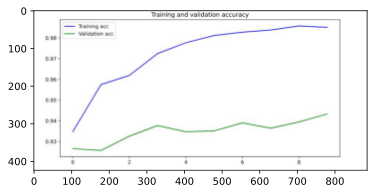

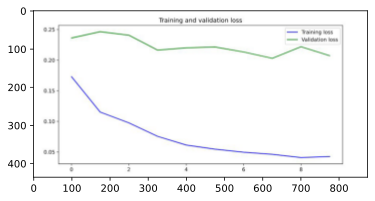

(875, 436)

In [40]:
#plot_history(history)
image = PIL.Image.open('../input/bestmodel3/bm41.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size
image = PIL.Image.open('../input/bestmodel3/bm42.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size

In [41]:
#обучим всю модель
#model.trainable = True
#len(model.trainable_variables)


In [42]:
LR                   = 0.0001
EPOCHS               = 10
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU


IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


#Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели,
#чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model4.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

#останоить обучение, когда метрика перестает улучшаться.
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights = True)

#Снижайть скорость обучения, когда метрика перестает улучшаться.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, min_lr=0.000000001, verbose=1, mode='auto')
    
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [43]:
#Обучаем модель
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = train_generator.samples//train_generator.batch_size,
#        validation_data = test_generator, 
#        validation_steps = test_generator.samples//test_generator.batch_size,
#        epochs = 10,
#        callbacks = callbacks_list
#)

In [44]:
#model.save('../working/model_step4.hdf5')
#model.load_weights('best_model4.hdf5')

In [45]:
#scores = model.evaluate_generator(test_generator, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 38s 1s/step - loss: 0.2392 - accuracy: 0.9416
Accuracy: 94.16%

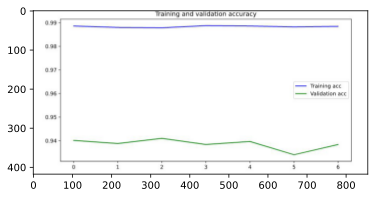

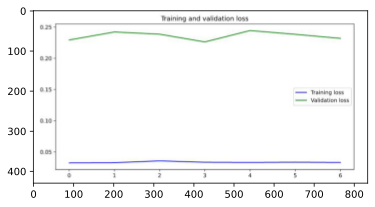

(834, 430)

In [46]:
#plot_history(history)
image = PIL.Image.open('../input/basemodel5/bm51.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size
image = PIL.Image.open('../input/basemodel5/bm52.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size

In [47]:
#увеличим размер изображения
LR                   = 0.0001
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [48]:
#Аугментация данных
train_datagen = ImageDataGenerator(
    rescale=1. / 255, #коэффициент масштабирования. По умолчанию - Нет. Если Нет или 0, 
    #масштабирование не применяется, в противном случае мы умножаем данные на предоставленное значение 
    #(после применения всех остальных преобразований).
    
    rotation_range = 10, #угол случайных поворотов
    width_shift_range = 0.1, #диапазон сдвига ширины
    height_shift_range = 0.1, #диапазон сдвига высоты
    brightness_range =  [0.5, 1.5], # сдвиг яркости
    validation_split = 0.05, # Доля выборки для валидации 
    horizontal_flip = True  # отражение по горизонтали
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [49]:
#Генерация данных
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 773 images belonging to 10 classes.
Found 6675 validated image filenames.


In [50]:
#Строим модель
import efficientnet.tfkeras as efn
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)  #Pooling слой
x = Dense(256, activation='elu')(x) # полносвязный слой с активацией elu
x = BatchNormalization()(x) #добавим Batch нормализацию
x = Dropout(0.25)(x) # полносвязный слой с вероятность отключения нейронов в слое
#x = BatchNormalization(axis = 1)(x) #добавим Batch нормализацию
predictions = Dense(CLASS_NUM, activation='softmax')(x) #логистический слой c нас 10 классами

# первая векрсия модели
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

165527552/165527152 [==============================] - 2s 0us/step


In [51]:
model.load_weights('../input/basemodel5/best_model4(1).hdf5')

In [52]:
#Обучаем модель
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = train_generator.samples//train_generator.batch_size,
#        validation_data = test_generator, 
#        validation_steps = test_generator.samples//test_generator.batch_size,
#        epochs = 10,
#        callbacks = callbacks_list
#)

Epoch 1/10
3697/3697 [==============================] - 2484s 664ms/step - loss: 0.6973 - accuracy: 0.8042 - val_loss: 0.1836 - val_accuracy: 0.9637

Epoch 00001: saving model to best_model4.hdf5
Epoch 2/10
3697/3697 [==============================] - 2456s 664ms/step - loss: 0.3248 - accuracy: 0.9042 - val_loss: 0.1546 - val_accuracy: 0.9663

Epoch 00002: saving model to best_model4.hdf5
Epoch 3/10
3697/3697 [==============================] - 2449s 662ms/step - loss: 0.2379 - accuracy: 0.9238 - val_loss: 0.1355 - val_accuracy: 0.9650

Epoch 00003: saving model to best_model4.hdf5
Epoch 4/10
3697/3697 [==============================] - 2450s 663ms/step - loss: 0.1896 - accuracy: 0.9417 - val_loss: 0.1323 - val_accuracy: 0.9715

Epoch 00004: saving model to best_model4.hdf5
Epoch 5/10
3697/3697 [==============================] - 2451s 663ms/step - loss: 0.1700 - accuracy: 0.9452 - val_loss: 0.1219 - val_accuracy: 0.9728

Epoch 00005: saving model to best_model4.hdf5
Epoch 6/10
3697/3697 [==============================] - 2443s 661ms/step - loss: 0.1454 - accuracy: 0.9546 - val_loss: 0.1485 - val_accuracy: 0.9715

Epoch 00006: saving model to best_model4.hdf5
Epoch 7/10
3697/3697 [==============================] - 2448s 662ms/step - loss: 0.1310 - accuracy: 0.9579 - val_loss: 0.1307 - val_accuracy: 0.9702

Epoch 00007: saving model to best_model4.hdf5

Epoch 00007: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 8/10
3697/3697 [==============================] - 2452s 663ms/step - loss: 0.0934 - accuracy: 0.9709 - val_loss: 0.1431 - val_accuracy: 0.9715

Epoch 00008: saving model to best_model4.hdf5
Epoch 9/10
3697/3697 [==============================] - 2449s 662ms/step - loss: 0.0686 - accuracy: 0.9803 - val_loss: 0.1551 - val_accuracy: 0.9702

Epoch 00009: saving model to best_model4.hdf5

Epoch 00009: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


In [53]:
#model.save('../working/model_step4.hdf5')
model.load_weights('../input/bestmodel6/best_model4(3).hdf5')

In [54]:
#scores = model.evaluate_generator(test_generator, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

194/194 [==============================] - 51s 264ms/step - loss: 0.1236 - accuracy: 0.9651
Accuracy: 96.51%


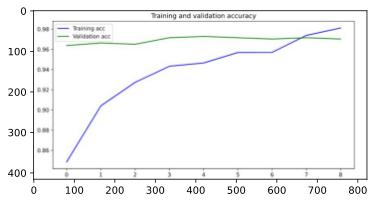

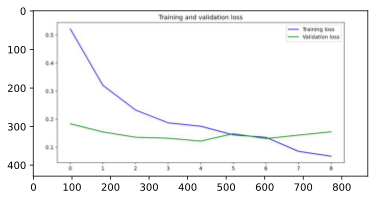

(868, 429)

In [55]:
#plot_history(history)
image = PIL.Image.open('../input/bestmodel6/bm61.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size
image = PIL.Image.open('../input/bestmodel6/bm62.JPG')
imgplot = plt.imshow(image)
plt.show()
image.size

In [56]:
#Предсказываем на тестовых данных
test_sub_generator.samples

6675

In [57]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 192s 111ms/step


In [58]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission1.csv', index=False)
print('Save submit')

Save submit


In [59]:
#Добавим Test Time Augmentation (TTA). Подробнее читайте в статье на towardsdatascience.

In [60]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


In [65]:
# генерируем новые аугментированные данные
test_datagen = ImageDataGenerator(
    rotation_range=5,                                  
    brightness_range=[0.5, 2.5],                            
    width_shift_range=0.1,                                  
    height_shift_range=0.1,                                  
    horizontal_flip=True,      
    rescale=1. / 255
    )


test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


Пример картинок из test_generator


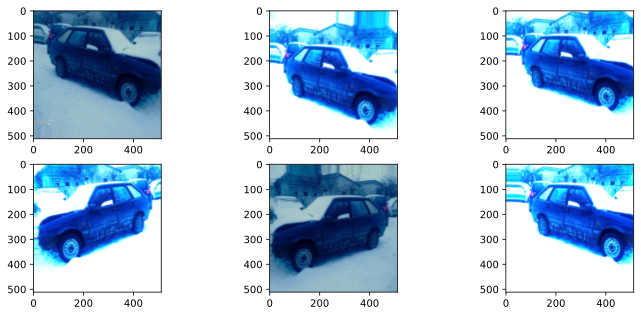

In [73]:
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    x = test_sub_generator[0]
    image = x[0]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [74]:
predictions = []

for i in range(10):
    preds = model.predict_generator(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 505s 302ms/step


In [75]:
pred[:2]

array([[8.14196246e-05, 8.82365748e-06, 1.16100706e-01, 9.50023677e-05,
        2.10975031e-05, 1.55034009e-04, 3.27884365e-04, 8.37466359e-01,
        2.38186061e-07, 4.57434580e-02],
       [7.22186905e-06, 1.10416943e-06, 4.75337894e-11, 1.48738692e-07,
        2.01826651e-06, 1.72765025e-09, 9.99989390e-01, 3.34768914e-11,
        1.23716831e-07, 2.84251678e-10]], dtype=float32)

In [76]:
predictions = np.argmax(pred, axis=-1) #индекс максимального значения
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_tta.csv', index=False)
print('Save submit')

Save submit


In [77]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,7


рейтинг в лидерборде увеличился с 0.97588 до 0.97692

In [ ]:
preds = model.predict_generator(test_sub_generator, verbose=1) 

In [ ]:
x = test_sub_generator[0]
image = x[0]
imgplot = plt.imshow(image)
plt.show()